In [1]:
import qiskit
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_distribution
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
import math
import numpy as np

## Example: [Travelling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

Consider a fully connected undirectional n nodes graph.  Each connection associates a weight (or distance).  Find a path to visit each node once and return to the starting node such that the total weight is minimum.

### Deviation from the original problem

Instead of finding the minimum, this implementation finds paths less than or equal to an input total distance.

### Outline

Use Grover's algorithm with the oracle to check the followings.

1. A validpath is a permutation of n nodes.
2. Add the distances for the n edges according to the path.  Accept if less than or equal to the input total distance.

### Supporting functions

Function ```create_adder()``` was explained in https://github.com/thyung/qiskit_factorization/blob/master/04_implement.ipynb 

In [2]:
# implement adder to add qubits a to qubits b and store the sum in b

def create_carrier(name=None, draw=False):
    c0 = QuantumRegister(1, 'c0')
    a0 = QuantumRegister(1, 'a0')
    b0 = QuantumRegister(1, 'b0')
    c1 = QuantumRegister(1, 'c1')
    qc = QuantumCircuit(c0, a0, b0, c1)
    qc.ccx(1, 2, 3)
    qc.cx(1, 2)
    qc.ccx(0, 2, 3)
    qc.cx(1, 2)
    if draw:
        display(qc.draw())
    return qc.to_gate(label=name or 'carrier')

def create_carrier_inv(name=None):
    qc = QuantumCircuit(4)
    qc.append(create_carrier().inverse(), range(4))
    return qc.to_gate(label=name or 'carrier_inv')

def create_sum(name=None, draw=False):
    c0 = QuantumRegister(1, 'c0')
    a0 = QuantumRegister(1, 'a0')
    b0 = QuantumRegister(1, 'b0')
    qc = QuantumCircuit(c0, a0, b0)
    qc.cx(a0, b0)
    qc.cx(c0, b0)
    if draw:
        display(qc.draw())
    return qc.to_gate(label=name or 'sum')

def create_sum_inv(name=None):
    qc = QuantumCircuit(3)
    qc.append(create_sum().inverse(), range(3))
    return qc.to_gate(label=name or 'sum_inv')

def create_adder(n, name=None, draw=False):
    """
    create adder with n bits a, n+1 bits b and n bits carrier
    """
    a = QuantumRegister(n, 'a')
    b = QuantumRegister(n+1, 'b')
    c = QuantumRegister(n, 'c')
    qc = QuantumCircuit(a, b, c)
    for i in range(n-1):
        qc.append(create_carrier(), [c[i], a[i], b[i], c[i+1]])
    qc.append(create_carrier(), [c[n-1], a[n-1], b[n-1], b[n]])
    
    qc.append(create_sum(), [c[n-1], a[n-1], b[n-1]])
    for i in reversed(range(n-1)):
        qc.append(create_carrier_inv(), [c[i], a[i], b[i], c[i+1]])
        qc.append(create_sum(), [c[i], a[i], b[i]])
    if draw:
        display(qc.draw())
    return qc.to_gate(label=name or 'adder')

def create_adder_inv(n, name=None):
    qc = QuantumCircuit(3*n+1)
    qc.append(create_adder(n).inverse(), range(3*n+1))
    return qc.to_gate(label=name or 'adder_inv')


Function ```create_adder_a()``` is a modified version of ```create_adder()``` where one of the operands becomes function parameter.

In [3]:
# implement adder to add function parameter v to qubits accumulator a

def create_carrier_a(v, name=None, draw=False):
    c0 = QuantumRegister(1, 'c0')
    a0 = QuantumRegister(1, 'a0')
    c1 = QuantumRegister(1, 'c1')
    qc = QuantumCircuit(c0, a0, c1)
    if v == 0:
        qc.ccx(c0, a0, c1)
    elif v == 1:
        qc.cx(a0, c1)
        qc.x(a0)
        qc.ccx(c0, a0, c1)
        qc.x(a0)
    if draw:
        display(qc.draw())
    return qc.to_gate(label=name or f'carrier_a_{v}')

def create_carrier_a_inv(v, name=None):
    qc = QuantumCircuit(3)
    qc.append(create_carrier_a(v).inverse(), [0, 1, 2])
    return qc.to_gate(label=name or f'carrier_a_inv_{v}')

def create_sum_a(v, name=None, draw=False):
    c0 = QuantumRegister(1, 'c0')
    a0 = QuantumRegister(1, 'a0')
    qc = QuantumCircuit(c0, a0)
    if v == 0:
        qc.cx(c0, a0)
    elif v == 1:
        qc.x(a0)
        qc.cx(c0, a0)
    if draw:
        display(qc.draw())
    return qc.to_gate(label=name or f'sum_a_{v}')

def create_sum_a_inv(v, name=None):
    qc = QuantumCircuit(2)
    qc.append(create_sum_a(v).inverse(), [0, 1])
    return qc.to_gate(label=name or f'sum_a_inv_{v}')

def create_adder_a(v, n, name=None, draw=False):
    """
    create adder with n+1 bits a and n bits carrier
    parameter v is added to a
    """
    if n < 2:
        return
    a = QuantumRegister(n+1, 'a')
    c = QuantumRegister(n, 'c')
    qc = QuantumCircuit(a, c)
    temp_v = v
    temp_v_array = []
    for i in range(n-1):
        temp_v0 = temp_v % 2
        temp_v_array.append(temp_v0)
        temp_v = temp_v // 2
        qc.append(create_carrier_a(temp_v0), [c[i], a[i], c[i+1]])
    temp_v0 = temp_v % 2
    temp_v_array.append(temp_v0)
    qc.append(create_carrier_a(temp_v0), [c[n-1], a[n-1], a[n]])

    qc.append(create_sum_a(temp_v0), [c[n-1], a[n-1]])
    for i in reversed(range(n-1)):
        qc.append(create_carrier_a_inv(temp_v_array[i]), [c[i], a[i], c[i+1]])
        qc.append(create_sum_a(temp_v_array[i]), [c[i], a[i]])
    if draw:
        display(qc.draw())
    return qc.to_gate(label=name or f'adder_a_{v}')
    
def create_adder_a_inv(v, n, name=None):
    qc = QuantumCircuit(2*n+1)
    qc.append(create_adder_a(v, n).inverse(), range(2*n+1))
    return qc.to_gate(label=name or f'adder_a_inv_{v}')


### Experience with too small path distance requirement

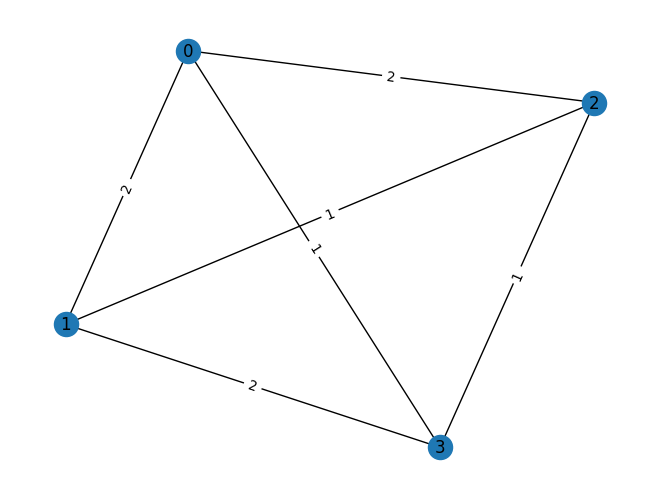

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
nodes = [0, 1, 2, 3]
G.add_nodes_from(nodes)

edges = [(0, 1, 2), (0, 2, 2), (0, 3, 1), (1, 2, 1), (1, 3, 2), (2, 3, 1)]
G.add_weighted_edges_from(edges)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

The shortest path distance is known to be 5.  If DIST_MAX_VALUE is set to 4, there is no feasible solution.  There is no outstanding frequency for any measured state.

### Implementation outline

1. The first part of $\operatorname{U_\omega}$ checks if qubits ```x``` represents a permutation of nodes.  In this example, ```x[0:2]```, ```x[2:4]```, ```x[4:6]``` and ```x[6:8]``` needs to be a permutation of 0, 1, 2 and 3.  If any 2 nodes represent the same value, add 1 to ```samenode_acc```.
2. The second part of $\operatorname{U_\omega}$ set ```edge_dist``` to edge distance/weight according to the 2 nodes represented by ```(x[0:2], x[2:4])``` and add the distance to ```dist_acc```.  Then, repeat for ```(x[2:4], x[4:6])```, ```(x[4:6], x[6:8])``` and ```(x[6:8], x[0:2])```
3. Add $2^{\operatorname{DIST\_MAX\_BITS}} - \operatorname{DIST\_MAX\_VALUE} - 1$ to ```dist_acc```.
4. If ```samenode_acc``` is zero and ```dist_acc``` does not overflow to ```high_acc```, controlled-NOT to ```y``` as phase kickback.
5. Reverse the operation to restore the state of all qubits except ```y```.
6. Then, apply $\operatorname{U_s}$.
7. Repeat $\operatorname{U_\omega}$ and $\operatorname{U_s}$ according to $r \approx \frac{2^\frac{n}{2}}{\sqrt{m}}$.  In this case, $n=8$ and $m=8$ (any 4 nodes closed path has 8 permutations).  $r \approx 2.8$.  If there is solution, run once can raise the measured frequency of the solution value ```x```.
8. Totally, 24 qubits.

In [5]:
# map 2 nodes to all possible edges weights, accumulate for the cyclic path

from qiskit import QuantumRegister
from qiskit import QuantumRegister
from qiskit import QuantumCircuit

DIST_MAX_VALUE = 4  # set too small and no path meet this requirement
DIST_MAX_BITS = 3   # number of bits to store operands.  The sum has DIST_MAX_BITS + 1 bits

def find_edges_weight(edges, node0, node1):
    """
    Find the edge weight between node0 and node1
    """
    for edge in edges:
        if (edge[0] == node0 and edge[1] == node1) or (edge[0] == node1 and edge[1] == node0):
            return edge[2]
    return 0

def is_twosamenodes_acc(qc, in0, in1, temp_compare_out, samenode_acc, high_acc, carry):
    """
    If in0 and in1 represent the same node, add 1 to samenode_acc.
    """
    if len(in0) != len(in1) or len(in1) != len(temp_compare_out):
        return False 
    for i in range(len(in0)):
        qc.cx(in1[i], temp_compare_out[i])
        qc.cx(in0[i], temp_compare_out[i])
        qc.x(temp_compare_out[i])
    qc.append(create_adder_a(1, 3).control(2), 
              temp_compare_out[:] + samenode_acc[:] + high_acc[:] + carry[:])
    for i in range(len(in0)):
        qc.x(temp_compare_out[i])
        qc.cx(in1[i], temp_compare_out[i])
        qc.cx(in0[i], temp_compare_out[i])
    return True

def is_twosamenodes_acc_inv(qc, in0, in1, temp_compare_out, samenode_acc, high_acc, carry):
    if len(in0) != len(in1) or len(in1) != len(temp_compare_out):
        return False 
    for i in range(len(in0)):
        qc.cx(in1[i], temp_compare_out[i])
        qc.cx(in0[i], temp_compare_out[i])
        qc.x(temp_compare_out[i])
    qc.append(create_adder_a_inv(1, 3).control(2), 
              temp_compare_out[:] + samenode_acc[:] + high_acc[:] + carry[:])
    for i in range(len(in0)):
        qc.x(temp_compare_out[i])
        qc.cx(in1[i], temp_compare_out[i])
        qc.cx(in0[i], temp_compare_out[i])
    return True

def is_anysamenode_acc(qc, num_nodes, num_bits_per_node, 
                       x, temp_compare_out, samenode_acc, high_acc, carry):
    """
    If any two nodes represent the same node, add 1 to samenode_acc.
    """
    for j in range(num_nodes-1):
        for i in range(j+1, num_nodes):
            is_twosamenodes_acc(qc, 
                            x[j*num_bits_per_node:(j+1)*num_bits_per_node], 
                            x[i*num_bits_per_node:(i+1)*num_bits_per_node], 
                            temp_compare_out, 
                            samenode_acc, high_acc, carry)
            qc.barrier()
            
def is_anysamenode_acc_inv(qc, num_nodes, num_bits_per_node,
                           x, temp_compare_out, samenode_acc, high_acc, carry):
    for j in reversed(range(num_nodes-1)):
        for i in reversed(range(j+1, num_nodes)):
            is_twosamenodes_acc_inv(qc,
                            x[i*num_bits_per_node:(i+1)*num_bits_per_node],
                            x[j*num_bits_per_node:(j+1)*num_bits_per_node],
                            temp_compare_out,
                            samenode_acc, high_acc, carry)
            qc.barrier()

def set_edge_dist(qc, node0, node1, dist, in0, in1, edge_dist):
    if len(in0) != len(in1):
        return False
    
    temp_node0 = node0
    for i in range(len(in0)):
        if temp_node0 % 2 == 0:
            qc.x(in0[i])
        temp_node0 = temp_node0 // 2
    temp_node1 = node1
    for i in range(len(in1)):
        if temp_node1 % 2 == 0:
            qc.x(in1[i])
        temp_node1 = temp_node1 // 2

    temp_dist = dist
    for i in range(len(edge_dist)):
        if temp_dist % 2 == 1:
            qc.mcx(in0[:] + in1[:], edge_dist[i])
        temp_dist = temp_dist // 2

    temp_node1 = node1
    for i in range(len(in1)):
        if temp_node1 % 2 == 0:
            qc.x(in1[i])
        temp_node1 = temp_node1 // 2
    temp_node0 = node0
    for i in range(len(in0)):
        if temp_node0 % 2 == 0:
            qc.x(in0[i])
        temp_node0 = temp_node0 // 2
    qc.barrier()
    return True
        

def set_alledges_dist(qc, edges, in0, in1, edge_dist):
    if len(in0) != len(in1):
        return False
    for edge in edges:
        set_edge_dist(qc, edge[0], edge[1], edge[2], in0, in1, edge_dist)
        set_edge_dist(qc, edge[1], edge[0], edge[2], in0, in1, edge_dist)
    return True

def set_alledges_dist_inv(qc, edges, in0, in1, edge_dist):
    if len(in0) != len(in1):
        return False
    for edge in reversed(edges):
        set_edge_dist(qc, edge[1], edge[0], edge[2], in0, in1, edge_dist)
        set_edge_dist(qc, edge[0], edge[1], edge[2], in0, in1, edge_dist)
    return True

def calc_pathdist_acc(qc, edges, num_nodes, num_bits_per_node,
                      x, edge_dist, dist_acc, high_acc, carry):
    """
    Accumulate the distance of the path.  dist_acc is the accumulated distance.
    high_acc is the carry of dist_acc.  
    """
    for i in range(num_nodes):
        next_node = (i + 1) % num_nodes
        set_alledges_dist(qc, 
                          edges, 
                          x[i*num_bits_per_node:(i+1)*num_bits_per_node],
                          x[next_node*num_bits_per_node:(next_node+1)*num_bits_per_node],
                          edge_dist) 
        qc.append(create_adder(len(dist_acc)), edge_dist[:] + dist_acc[:] + high_acc[:] + carry[:len(dist_acc)])
        qc.barrier()
        set_alledges_dist_inv(qc,
                              edges,
                              x[i*num_bits_per_node:(i+1)*num_bits_per_node],
                              x[next_node*num_bits_per_node:(next_node+1)*num_bits_per_node],
                              edge_dist)
    return True

def calc_pathdist_acc_inv(qc, edges, num_nodes, num_bits_per_node,
                          x, edge_dist, dist_acc, high_acc, carry):
    for i in reversed(range(num_nodes)):
        next_node = (i + 1) % num_nodes
        set_alledges_dist_inv(qc,
                              edges,
                              x[i*num_bits_per_node:(i+1)*num_bits_per_node],
                              x[next_node*num_bits_per_node:(next_node+1)*num_bits_per_node],
                              edge_dist)
        qc.append(create_adder_inv(len(dist_acc)), edge_dist[:] + dist_acc[:] + high_acc[:] + carry[:len(dist_acc)])
        qc.barrier()
        set_alledges_dist(qc,
                          edges,
                          x[i*num_bits_per_node:(i+1)*num_bits_per_node],
                          x[next_node*num_bits_per_node:(next_node+1)*num_bits_per_node],
                          edge_dist)
    return True

def append_tsp_U_w(qc, edges, dist_max, num_nodes, num_bits_per_node, 
                   x, temp_compare_out, samenode_acc, edge_dist, dist_acc, high_acc, carry, y):
    is_anysamenode_acc(qc, num_nodes, num_bits_per_node,
                     x, temp_compare_out, samenode_acc, high_acc, carry[:3])
    calc_pathdist_acc(qc, edges, num_nodes, num_bits_per_node,
                      x, edge_dist, dist_acc, high_acc, carry)

    qc.append(create_adder_a(2**len(dist_acc) - dist_max - 1, len(dist_acc)),
              dist_acc[:] + high_acc[:] + carry[:])
    qc.barrier()
    qc.x(samenode_acc)
    qc.x(high_acc)
    qc.mcx(samenode_acc[:] + high_acc[:], y)
    qc.x(high_acc)
    qc.x(samenode_acc)
    qc.barrier()
    qc.append(create_adder_a_inv(2**len(dist_acc) - dist_max - 1, len(dist_acc)),
              dist_acc[:] + high_acc[:] + carry[:])
    qc.barrier()

    calc_pathdist_acc_inv(qc, edges, num_nodes, num_bits_per_node,
                          x, edge_dist, dist_acc, high_acc, carry)
    is_anysamenode_acc_inv(qc, num_nodes, num_bits_per_node,
                           x, temp_compare_out, samenode_acc, high_acc, carry[:3])

    return True

def append_tsp_U_s(qc, x, y):
    qc.h(x)
    qc.barrier()

    qc.x(x)
    qc.mcx(x, y)
    qc.x(x)
    qc.barrier()

    qc.h(x)
    qc.barrier()
    return True

x = QuantumRegister(8, 'x')
temp_compare_out = QuantumRegister(2, 'temp_compare_out')
samenode_acc = QuantumRegister(3, 'samenode_acc') # if acc is zero, it is permutation
edge_dist = QuantumRegister(DIST_MAX_BITS, 'edge_dist')
dist_acc = QuantumRegister(DIST_MAX_BITS, 'dist_acc')
high_acc = QuantumRegister(1, 'high_acc')
carry = QuantumRegister(DIST_MAX_BITS, 'carry')
y = QuantumRegister(1, 'y')
cx = ClassicalRegister(8, 'cx')

tsp_qc = QuantumCircuit(x, temp_compare_out, samenode_acc, edge_dist, dist_acc, high_acc, carry, y, cx)
tsp_qc.h(x)
tsp_qc.x(y)
tsp_qc.h(y)
append_tsp_U_w(tsp_qc, edges, DIST_MAX_VALUE, 4, 2, x, temp_compare_out, samenode_acc, edge_dist, dist_acc, high_acc, carry, y)
append_tsp_U_s(tsp_qc, x, y)

tsp_qc.measure(x, cx)

Draw the circuit.

In [6]:
tsp_qc.draw('mpl', fold=120)

Execute the circuit.  This takes time.  It takes 25 minutes on M1 Macbook. 

In [7]:
sampler = StatevectorSampler()
job = sampler.run([tsp_qc])
result = job.result()[0]
samp_dist = result.data.cx.get_counts()

Draw the distribution.  The x labels are messed by $2^8$ of 8 digits binary numbers.

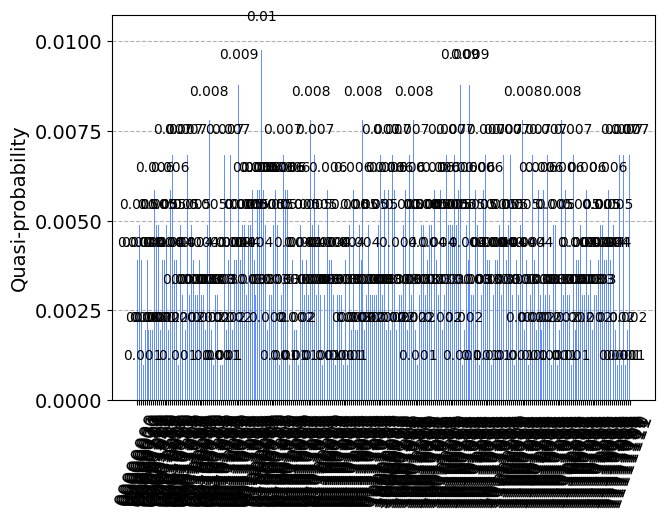

In [8]:
plot_distribution(samp_dist)

List the paths with significant high measured frequency. However, there is no feasible solution with given distance 4.

In [9]:
def get_path_dist(num_nodes, num_bits_per_node, state, edges):
    path = []
    for i in reversed(range(num_nodes)):
        path.append(int(state[i*num_bits_per_node:(i+1)*num_bits_per_node], 2))
    dist = 0
    for i in range(num_nodes):
        j = (i + 1) % len(path)
        dist += find_edges_weight(edges, path[i], path[j])
    return path, dist

def print_path_dist(num_nodes, num_bits_per_node, edges, threshold, samp_dist):
    num_path = 0
    path_dist_list = []
    for k, v in samp_dist.items():
        if v > threshold:
            path, dist = get_path_dist(num_nodes, num_bits_per_node, k, edges)
            path_dist_list.append((path, dist))
            print(f"path = {path}, dist = {dist}")
            num_path += 1
    if num_path == 0:
        print("No path found with frequency more than 20.")
    return path_dist_list

path_dist_list = print_path_dist(4, 2, edges, 20, samp_dist)

No path found with frequency more than 20.


### Experience with a feasible path distance requirement

In [10]:
DIST_MAX_VALUE = 5  # set a feasible path distance
DIST_MAX_BITS = 3

tsp_qc = QuantumCircuit(x, temp_compare_out, samenode_acc, edge_dist, dist_acc, high_acc, carry, y, cx)
tsp_qc.h(x)
tsp_qc.x(y)
tsp_qc.h(y)
append_tsp_U_w(tsp_qc, edges, DIST_MAX_VALUE, 4, 2, x, temp_compare_out, samenode_acc, edge_dist, dist_acc, high_acc, carry, y)
append_tsp_U_s(tsp_qc, x, y)

tsp_qc.measure(x, cx)

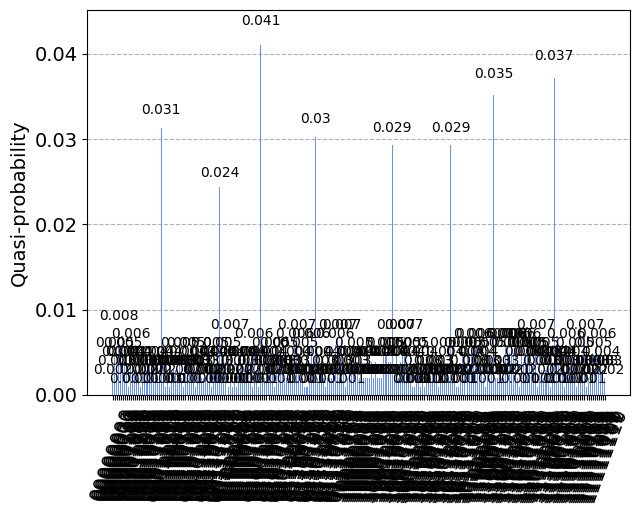

In [11]:
sampler = StatevectorSampler()
job = sampler.run([tsp_qc])
result = job.result()[0]
samp_dist = result.data.cx.get_counts()
plot_distribution(samp_dist)

List the paths with high measured frequency. 

In [12]:
path_dist_list = print_path_dist(4, 2, edges, 20, samp_dist)

path = [3, 0, 1, 2], dist = 5
path = [0, 1, 2, 3], dist = 5
path = [2, 3, 0, 1], dist = 5
path = [3, 2, 1, 0], dist = 5
path = [2, 1, 0, 3], dist = 5
path = [1, 0, 3, 2], dist = 5
path = [0, 3, 2, 1], dist = 5
path = [1, 2, 3, 0], dist = 5


Draw the solution path.

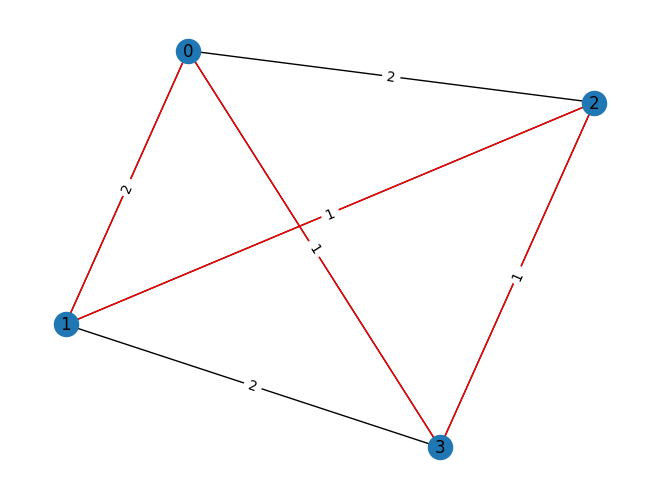

In [13]:
def draw_graph_solution(G, pos, path_sol):
    edges_sol = []
    for i in range(len(path_sol)):
        j = (i + 1) % len(path_sol)
        edges_sol.append((path_sol[i], path_sol[j]))
    nx.draw(G, pos, with_labels=True)
    nx.draw_networkx_edges(G, pos, edgelist=edges_sol, edge_color='r')
    edge_labels2 = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels2)
    plt.show()

draw_graph_solution(G, pos, path_dist_list[0][0])

Actually, there are 3 unique closed paths for 4 nodes undirected graph.  The found path is one of them with minimum distance 5.

### Experience with larger weight

More qubits are required to process larger weight.  This example increase the distance capability by 1 bit which increase 1 qubits for edge_dist, dist_acc and carry qubit registers by 1 respectively.  Totally, 27 qubits.

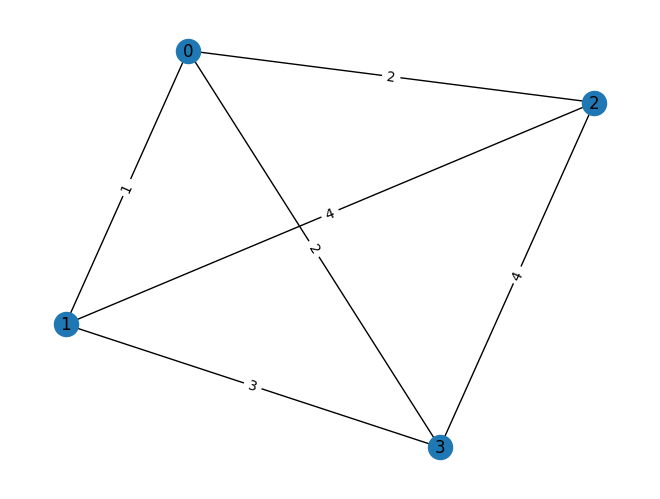

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

G2 = nx.Graph()
nodes = [0, 1, 2, 3]
G2.add_nodes_from(nodes)

edges2 = [(0, 1, 1), (0, 2, 2), (0, 3, 2), (1, 2, 4), (1, 3, 3), (2, 3, 4)]
G2.add_weighted_edges_from(edges2)

#pos = nx.spring_layout(G2) # commented reuse same layout as previous graph
nx.draw(G2, pos, with_labels=True)
edge_labels2 = nx.get_edge_attributes(G2, 'weight')
nx.draw_networkx_edge_labels(G2, pos, edge_labels=edge_labels2)
plt.show()

In [15]:
DIST_MAX_VALUE = 10
DIST_MAX_BITS = 4

x2 = QuantumRegister(8, 'x')
temp_compare_out2 = QuantumRegister(2, 'temp_compare_out')
samenode_acc2 = QuantumRegister(3, 'samenode_acc') # if acc is zero, it is permutation
edge_dist2 = QuantumRegister(DIST_MAX_BITS, 'edge_dist')
dist_acc2 = QuantumRegister(DIST_MAX_BITS, 'dist_acc')
high_acc2 = QuantumRegister(1, 'high_acc')
carry2 = QuantumRegister(DIST_MAX_BITS, 'carry')
y2 = QuantumRegister(1, 'y')
cx2 = ClassicalRegister(8, 'cx')

tsp_qc2 = QuantumCircuit(x2, temp_compare_out2, samenode_acc2, edge_dist2, dist_acc2, high_acc2, carry2, y2, cx2)
tsp_qc2.h(x2)
tsp_qc2.x(y2)
tsp_qc2.h(y2)
append_tsp_U_w(tsp_qc2, edges2, DIST_MAX_VALUE, 4, 2, x2, temp_compare_out2, samenode_acc2, edge_dist2, dist_acc2, high_acc2, carry2, y2)
append_tsp_U_s(tsp_qc2, x2, y2)

tsp_qc2.measure(x2, cx2)

In [16]:
tsp_qc2.draw('mpl', fold=120)

Execute the circuit.  It took 2.5 hours to run on M1 Macbook (16G RAM) while the corresponding python process showed around 8G memory usage.

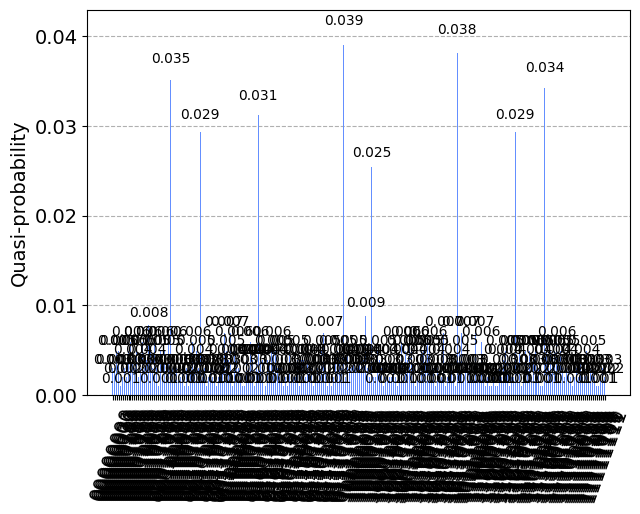

In [17]:
sampler = StatevectorSampler()
job2 = sampler.run([tsp_qc2])
result2 = job2.result()[0]
samp_dist2 = result2.data.cx.get_counts()
plot_distribution(samp_dist2)

List the paths with high measured frequency. 

In [18]:
path_dist_list2 = print_path_dist(4, 2, edges2, 20, samp_dist2)

path = [0, 2, 3, 1], dist = 10
path = [1, 3, 2, 0], dist = 10
path = [2, 0, 1, 3], dist = 10
path = [3, 1, 0, 2], dist = 10
path = [3, 2, 0, 1], dist = 10
path = [2, 3, 1, 0], dist = 10
path = [0, 1, 3, 2], dist = 10
path = [1, 0, 2, 3], dist = 10


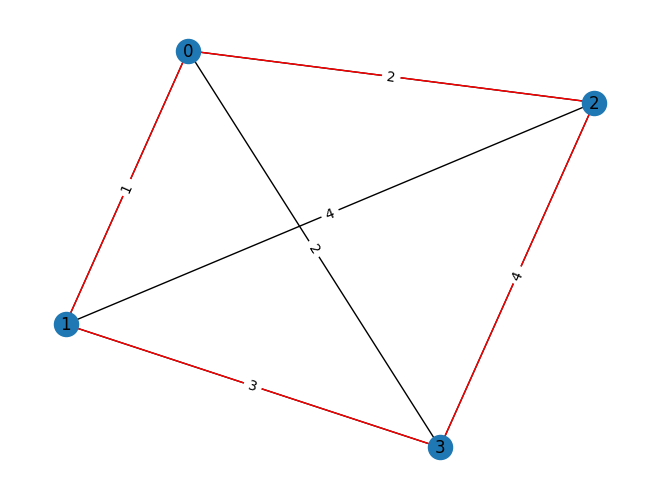

In [19]:
draw_graph_solution(G2, pos, path_dist_list2[0][0])

In [20]:
qiskit.__version__

'1.0.2'